Microeconometrics, SoSe 2020, Bonn University   
Student: Madina Japakhova

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reducing-Child-Mortality-in-the-Last-Mile:-Experimental-Evidence-on-Community-Health-Promoters-in-Uganda.-Replication-project." data-toc-modified-id="Reducing-Child-Mortality-in-the-Last-Mile:-Experimental-Evidence-on-Community-Health-Promoters-in-Uganda.-Replication-project.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reducing Child Mortality in the Last Mile: Experimental Evidence on Community Health Promoters in Uganda. Replication project.</a></span><ul class="toc-item"><li><span><a href="#Intro:-Mapping-Child-Mortality" data-toc-modified-id="Intro:-Mapping-Child-Mortality-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Intro: Mapping Child Mortality</a></span></li></ul></li><li><span><a href="#Balance-at-Baseline" data-toc-modified-id="Balance-at-Baseline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Balance at Baseline</a></span></li><li><span><a href="#Table-3---Treatment-Impact-on-Child-Mortality" data-toc-modified-id="Table-3---Treatment-Impact-on-Child-Mortality-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Table 3 - Treatment Impact on Child Mortality</a></span><ul class="toc-item"><li><span><a href="#Program-impact-on-the-number-of-deaths" data-toc-modified-id="Program-impact-on-the-number-of-deaths-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Program impact on the number of deaths</a></span></li><li><span><a href="#Program-impact-on-the-Mortality-per-1,000-years-of-exposure" data-toc-modified-id="Program-impact-on-the-Mortality-per-1,000-years-of-exposure-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Program impact on the Mortality per 1,000 years of exposure</a></span></li><li><span><a href="#Mortality-per-1000-births" data-toc-modified-id="Mortality-per-1000-births-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Mortality per 1000 births</a></span></li></ul></li><li><span><a href="#Table-4----Program-Impact-on-Child-Weight,-Height,-and-Hemoglobin-Levels" data-toc-modified-id="Table-4----Program-Impact-on-Child-Weight,-Height,-and-Hemoglobin-Levels-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Table 4 -- Program Impact on Child Weight, Height, and Hemoglobin Levels</a></span><ul class="toc-item"><li><span><a href="#Panel-A:-children-under-60-months" data-toc-modified-id="Panel-A:-children-under-60-months-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Panel A: children under 60 months</a></span></li><li><span><a href="#Panel-B:-Children-under-24-months" data-toc-modified-id="Panel-B:-Children-under-24-months-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Panel B: Children under 24 months</a></span></li><li><span><a href="#Panel-C:-children-between-24-and-60-months" data-toc-modified-id="Panel-C:-children-between-24-and-60-months-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Panel C: children between 24 and 60 months</a></span></li></ul></li><li><span><a href="#Table-5---Program-Impact-on-CHP-Interaction-and-Health-Knowledge" data-toc-modified-id="Table-5---Program-Impact-on-CHP-Interaction-and-Health-Knowledge-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Table 5 - Program Impact on CHP Interaction and Health Knowledge</a></span></li><li><span><a href="#Table-6---Program-Impact-on-Preventive-and-Treatment-Services" data-toc-modified-id="Table-6---Program-Impact-on-Preventive-and-Treatment-Services-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Table 6 - Program Impact on Preventive and Treatment Services</a></span></li><li><span><a href="#Extension" data-toc-modified-id="Extension-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Extension</a></span></li><li><span><a href="#Notes" data-toc-modified-id="Notes-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Notes</a></span></li></ul></div>

### Reducing Child Mortality in the Last Mile: Experimental Evidence on Community Health Promoters in Uganda. Replication project. 

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import ks_2samp
from linearmodels import PanelOLS
import statsmodels as sm
import statsmodels.regression.linear_model as sm 
from statsmodels.api import add_constant 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns  

In [2]:
import rpy2.rinterface
from rpy2.robjects import pandas2ri 
import rpy2.robjects as robjects 
%load_ext rpy2.ipython

C:\Users\ZEF\anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
%%R
library(tidyverse)
library(ggplot2)
library(foreign)
library(Hmisc)
library(ISOcodes)
library(plyr)
library(dplyr)
library(zscorer)
library(IRkernel)
IRkernel::installspec()
options(scipen = 999)

####  Intro: Mapping Child Mortality 
The paper starts with a general discussion on child mortality. In particular, the authors bring up the following facts: 
a) about 1 in 13 children in sub-Saharan Africa still die before his or her fifth birthday (WHO 2017)
b) most of these deaths are easily preventable through simple inexpensive treatments delivered at home

And indeed a closer look at the WHO data substantiates this saddening statistics. The map[<sup>1</sup>](#fn1) below shows that relative to other regions, sub-Saharan Africa and Southeast Asia are especially vulnerable in front of child mortality. 

WHO uses the following definition of under-5 child mortality rate: the probability of dying between birth and age 5 per 1000 live births.  

**Figure 1: Mapping child mortality (WHO, 2017):**

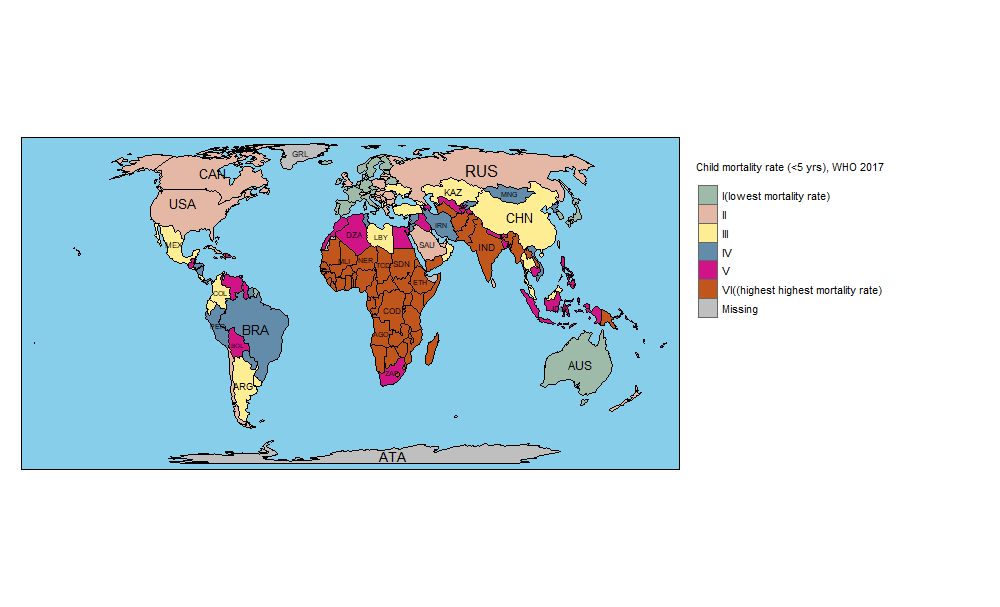

In [4]:
from IPython.display import Image
Image(filename='WHO_2017.png')  

Country of interest: Uganda. Located in the heart of sub-Saharan Africa, Uganda's under-5 child mortality rate is around 49 deaths per 1000 live births, which places it into the 6th group (countries with the highest mortality rates).

**Figure 2: Child mortality in Uganda (WHO, 2017):**

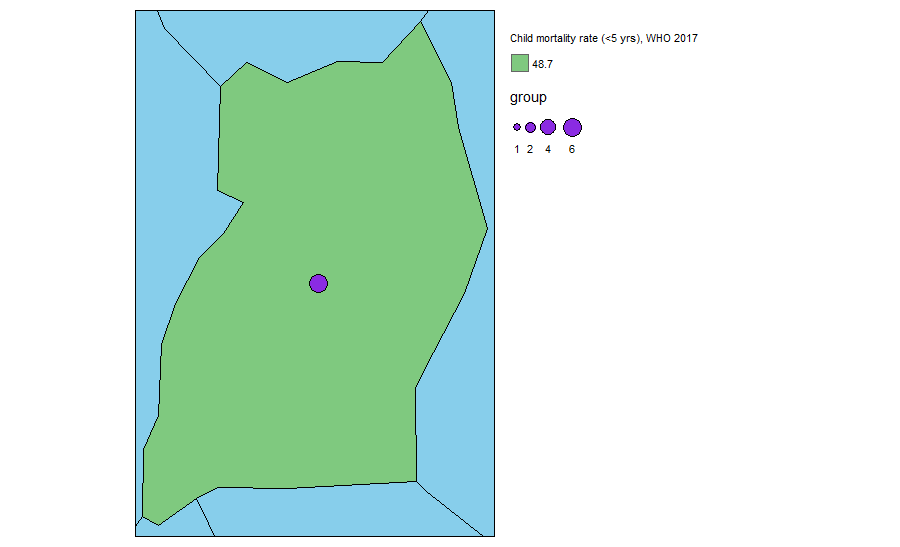

In [5]:
Image(filename='Uganda.png') 

### Balance at Baseline
Assignment procedure: a randomized trial (simple randomization). To see whether the randomization is well-balanced, we compare the means of the subjects' pretrial covariates.

In [6]:
baseline = pd.read_csv("AEJ2018_HHmain.csv")
baseline.index.set_names("Household", inplace = True)
pretrial_covariates = ["village_hhs_baseline", "village_hhsu5_baseline", "village_distance_road",
                      "village_distance_electricity", "village_distance_HF","village_HF_within5km",
                      "village_distance_HOSP"]
summary_statistics = baseline.groupby(["treatment", "villageid", "branchid"])[pretrial_covariates].mean()
summary_statistics = summary_statistics.groupby("treatment", as_index = False).agg(['mean', 'std'])
summary_statistics.columns = ["Households per cluster mean","Mean standard deviation",
                              "Households with under-5 children per cluster mean", "Mean standard deviation",
                              "Distance to main road mean", "Mean standard deviation",
                              "Distance to electricity translission line mean", "Mean standard deviation",
                              "Distance to health center mean","Mean standard deviation",
                              "Number of health centers within 5 km mean","Mean standard deviation",
                              "Distance to hospital mean","Mean standard deviation"]
summary_statistics = summary_statistics.round(decimals=1)
summary_statistics.T 

treatment,0,1
Households per cluster mean,221.1,249.8
Mean standard deviation,107.0,112.8
Households with under-5 children per cluster mean,78.0,86.5
Mean standard deviation,45.7,47.0
Distance to main road mean,6.8,5.6
Mean standard deviation,12.7,11.6
Distance to electricity translission line mean,1.8,1.8
Mean standard deviation,1.5,1.5
Distance to health center mean,1.7,1.4
Mean standard deviation,1.2,1.1


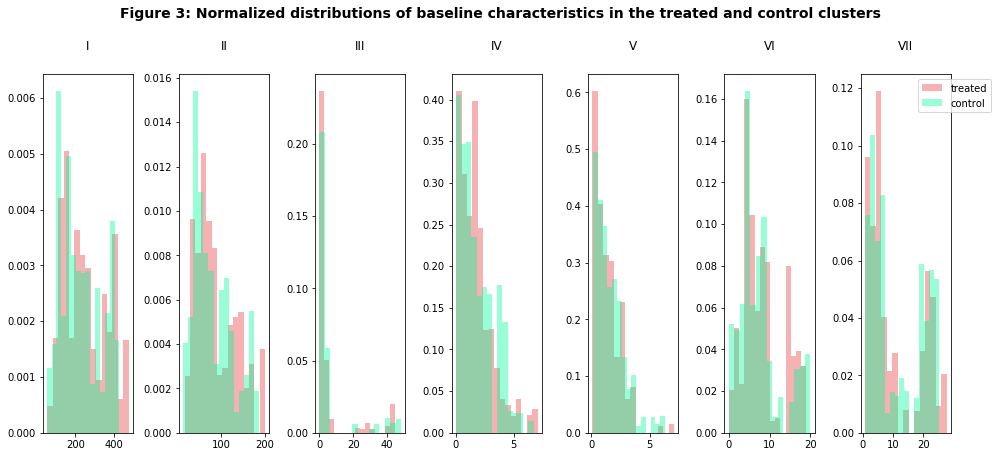

In [10]:
pretrials = baseline[["treatment", "village_hhs_baseline", "village_hhsu5_baseline", "village_distance_road",
                      "village_distance_electricity", "village_distance_HF","village_HF_within5km",
                      "village_distance_HOSP" ]] 
pretrials_treated = pretrials[pretrials.treatment == 1] 
pretrials_control = pretrials[pretrials.treatment == 0]
# Setting the weights for normalization 
x1 = pretrials_treated['village_hhs_baseline']
x1_w = np.empty(x1.shape) 
x1_w.fill(1/x1.shape[0]) 
x2 = pretrials_control['village_hhs_baseline']
x2_w = np.empty(x2.shape) 
x2_w.fill(1/x2.shape[0])

x3 = pretrials_treated['village_hhsu5_baseline']
x3_w = np.empty(x3.shape) 
x3_w.fill(1/x3.shape[0])
x4 = pretrials_control['village_hhsu5_baseline'] 
x4_w = np.empty(x4.shape) 
x4_w.fill(1/x4.shape[0])

x5 = pretrials_treated['village_distance_road'] 
x5_w = np.empty(x5.shape) 
x5_w.fill(1/x5.shape[0])
x6 = pretrials_control['village_distance_road']
x6_w = np.empty(x6.shape) 
x6_w.fill(1/x6.shape[0])

x7 = pretrials_treated['village_distance_electricity'] 
x7_w = np.empty(x7.shape) 
x7_w.fill(1/x7.shape[0])
x8 = pretrials_control['village_distance_electricity'] 
x8_w = np.empty(x8.shape) 
x8_w.fill(1/x8.shape[0])

x9 = pretrials_treated['village_distance_HF'] 
x9_w = np.empty(x9.shape) 
x9_w.fill(1/x9.shape[0])
x10 = pretrials_control['village_distance_HF'] 
x10_w = np.empty(x10.shape) 
x10_w.fill(1/x10.shape[0])

x11 = pretrials_treated['village_HF_within5km'] 
x11_w = np.empty(x11.shape) 
x11_w.fill(1/x11.shape[0])
x12 = pretrials_control['village_HF_within5km']  
x12_w = np.empty(x12.shape) 
x12_w.fill(1/x12.shape[0])

x13 = pretrials_treated['village_distance_HOSP']  
x13_w = np.empty(x13.shape) 
x13_w.fill(1/x13.shape[0])
x14 = pretrials_control['village_distance_HOSP'] 
x14_w = np.empty(x14.shape) 
x14_w.fill(1/x14.shape[0]) 

# Plotting 
fig, axs = plt.subplots(1,7, figsize = (14,6), sharey = False)

axs[0].hist(x1, bins = 15, weights = x1_w, label = 'treated', color = "lightcoral",
            density = True, alpha = 0.6) 
axs[0].hist(x2, bins = 15, weights = x2_w, label = 'control', color = "mediumspringgreen",
            density = True, alpha = 0.4) 
axs[0].set_title(r'I') 

axs[1].hist(x3, bins = 15, weights = x3_w, label = 'treated', color = "lightcoral",
            density = True, alpha = 0.6) 
axs[1].hist(x4, bins = 15, weights = x4_w, label = 'control', color = "mediumspringgreen",
            density = True, alpha = 0.4) 
axs[1].set_title(r'II') 

axs[2].hist(x5, bins = 15, weights = x5_w, label = 'treated', color = "lightcoral",
            density = True, alpha = 0.6) 
axs[2].hist(x6, bins = 15, weights = x6_w, label = 'control', color = "mediumspringgreen",
            density = True, alpha = 0.4) 
axs[2].set_title(r'III')

axs[3].hist(x7, bins = 15, weights = x7_w, label = 'treated', color = "lightcoral",
            density = True, alpha = 0.6) 
axs[3].hist(x8, bins = 15, weights = x8_w, label = 'control', color = "mediumspringgreen",
            density = True, alpha = 0.4) 
axs[3].set_title(r'IV') 

axs[4].hist(x9, bins = 15, weights = x9_w, label = 'treated',color = "lightcoral",
            density = True, alpha = 0.6) 
axs[4].hist(x10, bins = 15, weights = x10_w, label = 'control', color = "mediumspringgreen",
            density = True, alpha = 0.4) 
axs[4].set_title(r'V') 

axs[5].hist(x11, bins = 15, weights = x11_w, label = 'treated', color = "lightcoral",
            density = True, alpha = 0.6) 
axs[5].hist(x12, bins = 15, weights = x12_w, label = 'control', color = "mediumspringgreen",
            density = True, alpha = 0.4) 
axs[5].set_title(r'VI')

axs[6].hist(x13, bins = 15, weights = x13_w, label = 'treated', color = "lightcoral",
            density = True, alpha = 0.6) 
axs[6].hist(x14, bins = 15, weights = x14_w, label = 'control', color = "mediumspringgreen",
            density = True, alpha = 0.4) 
axs[6].set_title(r'VII')

fig.suptitle(r'Figure 3: Normalized distributions of baseline characteristics in the treated and control clusters',
             fontsize = 14, fontweight = 'bold', y=1.05)
plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5))
plt.tight_layout()
plt.show()  

*Figure 3* illustrates that all the pretreatment characteristics are similarly distributed in the treated and control clusters - providing grounds for the claim that the two groups represent the same population.    

**Kolmogorov-Smirnov two-sample test**   

In the paper the authors ran a series of linear regressions to show that the differences in means for all pretrial cluster characteristics in both samples are not statistically significant. Pursuing the same purpose, I performed a two-sample Kolmogorov-Smirnov test. The choice of this non-parametric test is inspired with *Figure 3* and is an attempt to avoid making a common assumption on the shapes of the underlying distributions of the pretrial features.

In [8]:
for column in pretrials: 
    treated = pretrials[pretrials.treatment == 1][column] 
    control = pretrials[pretrials.treatment == 0][column] 
    stat = ks_2samp(treated, control)[1] 
    
    print(f"{column} {stat:7.3f}")    

treatment   1.000
village_hhs_baseline   1.000
village_hhsu5_baseline   1.000
village_distance_road   1.000
village_distance_electricity   1.000
village_distance_HF   1.000
village_HF_within5km   1.000
village_distance_HOSP   1.000


We fail to reject the null hypothesis, i.e. that the control and treated groups come from the same population. 

Additional evidence to support that treatment assignment among the clusters was well-balanced is that there is no association (*linear correlation coefficient $\geq$ 0.5*) between the treatment status and any of the baseline characteristics, which invalidates them as candidates for controls in regressions that follow. 

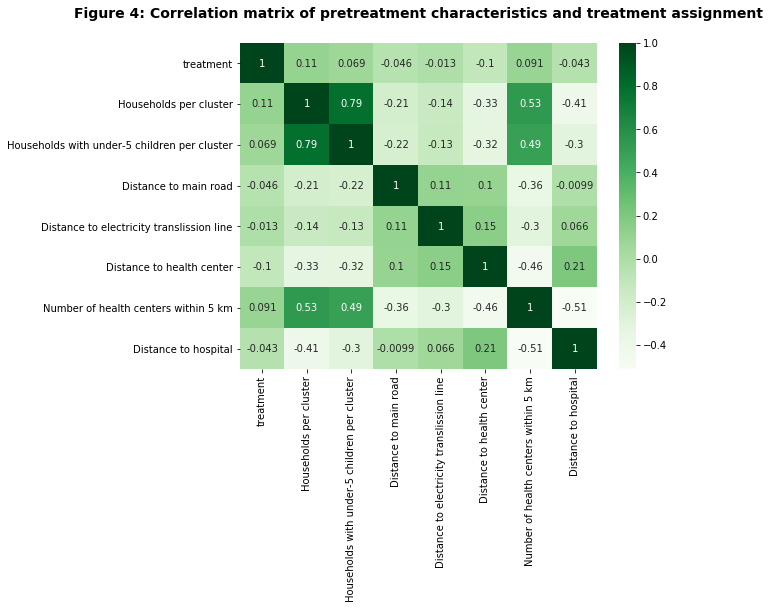

In [12]:
plt.figure(figsize=(8,6)) 
cor = pretrials.corr() 
labels = ["treatment", "Households per cluster", "Households with under-5 children per cluster", 
                              "Distance to main road", 
                              "Distance to electricity translission line", 
                              "Distance to health center",
                              "Number of health centers within 5 km",
                              "Distance to hospital",]
ax = sns.heatmap(cor, annot = True, cmap=plt.cm.Greens) 
ax.set_xticklabels(labels,fontsize=10)
ax.set_yticklabels(labels,fontsize=10)
rcParams['axes.titlepad'] = 25 # space between the title and the matrix
ax.set_title(r'Figure 4: Correlation matrix of pretreatment characteristics and treatment assignment',
             fontsize = 14, fontweight = 'bold')
plt.show()  

### Table 3 - Treatment Impact on Child Mortality


In [42]:
df = pd.read_stata("AEJ2018_child_mortality.dta", convert_missing = False) 
df.isnull().sum()
df_new = df.drop(df[df.datedeath_cmc< 1333].index)
#Generating indicators whether a child died before 5 years (60 motnhs),
#1 year(12 months), or whether a neonatal death occured(before 1 month of life)
df_new['death_u5'] = np.where((df_new['died']==1) & (df_new['aad']<60), 1, 0) 
df_new['death_u1'] = np.where((df_new['died']==1) & (df_new['aad']<12), 1, 0)
df_new['death_u1m'] = np.where((df_new['died'] == 1) & (df_new['aad']<1), 1,0) 
df_new = df_new.groupby(['villageid', 'branchid', 'treatment'], as_index = True)[['death_u5', 
'death_u1','death_u1m']].sum().reset_index()
df_new = df_new.set_index(['branchid', 'villageid'], drop = False)
treated = df_new[df_new.treatment == 1]
control = df_new[df_new.treatment == 0]
number_of_treated = treated['treatment'].count() 
number_of_controls = control['treatment'].count()
print(f"Trial beginning: {number_of_treated} treated clusters, {number_of_controls} control clusters")

Trial beginning: 115 treated clusters, 99 control clusters


In [43]:
df_new.describe() 

,villageid,branchid,treatment,death_u5,death_u1,death_u1m
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1427.602804,16.691589,0.537383,1.817757,1.373832,0.953271
std,255.135766,15.477630,0.499770,1.846062,1.535333,1.224808
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1306.250000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1411.500000,5.000000,1.000000,1.000000,1.000000,1.000000
75%,1632.750000,31.000000,1.000000,2.750000,2.000000,1.000000
max,1910.000000,42.000000,1.000000,14.000000,11.000000,7.000000


#### Program impact on the number of deaths

Below I've reproduced the results by Björkman et al. on the treatment impact on the number of deaths in 3 groups: under-5, infants, neonatal. Following the authors approach, I used the method of OLS with branch fixed effects.

Program impact on the number of child deaths

In [45]:
#Program impact on under 5 deaths
reg_1 = PanelOLS(df_new.death_u5,df_new.treatment, entity_effects = True)
res_1 = reg_1.fit(cov_type = 'clustered', clusters = df_new.villageid)

#Program impact on infant deaths
reg_2 = PanelOLS(df_new['death_u1'],add_constant(df_new['treatment']), entity_effects = True)
res_2 = reg_2.fit(cov_type = 'clustered', clusters = df_new.villageid) 

#Program impact on neonatal deaths 
X = ['treatment']
X = add_constant(df_new[X])
reg_3 = PanelOLS(df_new.death_u1m,X, entity_effects = True)
res_3 = reg_3.fit(cov_type = 'clustered', clusters = df_new.villageid)

print(res_1, res_2, res_3)  

                          PanelOLS Estimation Summary                           
Dep. Variable:               death_u5   R-squared:                        0.0280
Estimator:                   PanelOLS   R-squared (Between):             -0.2985
No. Observations:                 214   R-squared (Within):               0.0280
Date:                Tue, Jul 14 2020   R-squared (Overall):             -0.1768
Time:                        20:04:55   Log-likelihood                   -417.21
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.7951
Entities:                          12   P-value                           0.0170
Avg Obs:                       17.833   Distribution:                   F(1,201)
Min Obs:                       6.0000                                           
Max Obs:                       60.000   F-statistic (robust):             6.2657
                            

Treatment effect on the number of under 5 deaths, mean control:


In [13]:
mean_control_1 = sm.OLS(df_new['death_u5'],add_constant(df_new['treatment']))
mean_control_res_1 = mean_control_1.fit()
mean_control_res_1.summary2(yname="Under-5 deaths", xname=["Intercept", "Program impact"],
             title="Program Impact on Child Mortality", alpha=0.05, float_format='%.4f') 


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Program Impact on Child Mortality
=================================================================
Model:              OLS              Adj. R-squared:     0.013   
Dependent Variable: Under-5 deaths   AIC:                868.8993
Date:               2020-07-13 20:45 BIC:                875.6313
No. Observations:   214              Log-Likelihood:     -432.45 
Df Model:           1                F-statistic:        3.790   
Df Residuals:       212              Prob (F-statistic): 0.0529  
R-squared:          0.018            Scale:              3.3639  
-----------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           2.0808   0.1843 11.2883 0.0000  1.7174 2.4442
Program impact     -0.4895   0.2515 -1.9467 0.0529 -0.9852 0.0062
-----------------------------------------------------------------
Omnibus:              126.014      Durbin-Watson:         1.897  
Prob(Omnibus):        0.000        Jarque-Bera (JB):      968.651
Skew:                 2.188        Prob(JB):              0.000  
Kurtosis:             12.459       Condition No.:         3      
=================================================================

"""

Program impact on the number of infant deaths, mean control:

In [14]:
model = sm.OLS(df_new['death_u1'],add_constant(df_new['treatment']))
res = model.fit()
res.summary2(yname="Infant deaths", xname=["Intercept", "Program impact"],
             title="Program Impact on Child Mortality", alpha=0.05, float_format='%.4f') 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Program Impact on Child Mortality
=================================================================
Model:              OLS              Adj. R-squared:     0.017   
Dependent Variable: Infant deaths    AIC:                789.1457
Date:               2020-07-13 20:45 BIC:                795.8776
No. Observations:   214              Log-Likelihood:     -392.57 
Df Model:           1                F-statistic:        4.668   
Df Residuals:       212              Prob (F-statistic): 0.0318  
R-squared:          0.022            Scale:              2.3173  
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          1.6162   0.1530 10.5635 0.0000  1.3146  1.9177
Program impact    -0.4509   0.2087 -2.1607 0.0318 -0.8623 -0.0395
-----------------------------------------------------------------
Omnibus:              112.745      Durbin-Watson:         1.829  
Prob(Omnibus):        0.000        Jarque-Bera (JB):      665.563
Skew:                 2.005        Prob(JB):              0.000  
Kurtosis:             10.652       Condition No.:         3      
=================================================================

"""

Program impact on the number of neonatal deaths, mean control:

In [15]:
model = sm.OLS(df_new['death_u1m'],add_constant(df_new['treatment']))
res = model.fit()
res.summary2(yname="Neonatal deaths", xname=["Intercept", "Program impact"],
             title="Program Impact on Child Mortality", alpha=0.05, float_format='%.4f') 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Program Impact on Child Mortality
=================================================================
Model:              OLS              Adj. R-squared:     0.003   
Dependent Variable: Neonatal deaths  AIC:                695.3864
Date:               2020-07-13 20:46 BIC:                702.1184
No. Observations:   214              Log-Likelihood:     -345.69 
Df Model:           1                F-statistic:        1.699   
Df Residuals:       212              Prob (F-statistic): 0.194   
R-squared:          0.008            Scale:              1.4952  
-----------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           1.0707   0.1229  8.7123 0.0000  0.8285 1.3130
Program impact     -0.2185   0.1676 -1.3035 0.1938 -0.5490 0.1119
-----------------------------------------------------------------
Omnibus:             81.769       Durbin-Watson:          1.724  
Prob(Omnibus):       0.000        Jarque-Bera (JB):       218.602
Skew:                1.706        Prob(JB):               0.000  
Kurtosis:            6.587        Condition No.:          3      
=================================================================

"""

So far, I've replicated the first part of table-3 (Program Impact on Child Mortality). In particular, I've estimated the effect of the program on the number of child deaths in three age groups using the same method as  in the original paper - OlS with fixed effects. My results  coincide with the results of the paper, estimations of the treatment effects on the number of child deaths are very similar to the original findings in all 3 age groups.

#### Program impact on the Mortality per 1,000 years of exposure

In [16]:
data_2 = pd.read_stata("AEJ2018_child_mortality_computation.dta") 
data_2 = data_2.groupby(['villageid', 'branchid', 'treatment'], as_index = True)[['death_under5','count_month_u5',
'death_under1', 'count_month_u1','death_under1m','count_month_u1m']].sum().reset_index()
data_2 = data_2.set_index(['villageid', 'branchid'], drop = False)
data_2['count_month_u5'] = data_2.apply(lambda row: row.count_month_u5/12, axis = 1)
data_2['count_month_u1'] = data_2.apply(lambda row: row.count_month_u1/12, axis = 1)
data_2['mrate_u5'] = (data_2['death_under5']/data_2['count_month_u5'])*1000
data_2['mrate_u1'] = (data_2['death_under1']/data_2['count_month_u1'])*1000
data_2['mrate_u1m'] = (data_2['death_under1m']/data_2['count_month_u1m'])*1000
data_2.to_csv("data_for_table_3_prepared.csv")
data_2.describe()



,villageid,branchid,treatment,death_under5,count_month_u5,death_under1,count_month_u1,death_under1m,count_month_u1m,mrate_u5,mrate_u1,mrate_u1m
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1427.602804,16.691589,0.537383,1.817757,107.594237,1.373832,30.689447,0.953271,30.369160,16.611985,43.855541,29.433989
std,255.135766,15.477630,0.499770,1.846062,23.746709,1.535333,6.610219,1.224807,7.223409,15.680160,45.691946,35.540310
min,1001.000000,1.000000,0.000000,0.000000,38.208333,0.000000,8.708333,0.000000,7.000000,0.000000,0.000000,0.000000
25%,1306.250000,1.000000,0.000000,1.000000,92.187500,0.000000,27.052083,0.000000,27.000000,6.793686,0.000000,0.000000
50%,1411.500000,5.000000,1.000000,1.000000,108.687500,1.000000,31.270833,1.000000,31.000000,12.357873,32.345072,25.978408
75%,1632.750000,31.000000,1.000000,2.750000,123.479167,2.000000,34.656250,1.000000,35.000000,24.308293,67.346003,43.478260
max,1910.000000,42.000000,1.000000,14.000000,170.750000,11.000000,51.208333,7.000000,51.000000,92.383833,242.424242,161.290314


https://stackoverflow.com/questions/54507204/how-to-fix-the-absorbing-effect-error-when-trying-to-include-fixed-effects-in-th   I am facing the same absorbing error in this part of replicating table 3. I've tried using the same dataset prepared in Stata as authors did, it didn't work either. PanelOLS from linearmodels can't estimate the model, becuase the treatment effetc is somehow fully absorbed by branch fixed effect. After successfuly running OLS with a fixed effect on the exported dataset "data_for_table_3_prepared.csv" (see above) in R, and also after failing to estimate the model with *linearmodels* on the Stata prepared dataset (the one authors used), I believe there is something with linearmodels in this part of table 3. I filed an issue on the github repo of the package, they confirmed that I have an absorbing error, i.e. all of my X-s are absorbed by the entity effect. To make sure there is no collinearity between treatment status and branch id, I calculated the VIF:

In [17]:
cov1 = ['branchid'] 
cov1 =add_constant(data_2[cov1])
model = sm.OLS(data_2.treatment, cov1) 
results = model.fit() 
rsq = results.rsquared 
vif = round(1/(1-rsq),2) 
vif  


1.0

Since an OLS without a fixed effect results in a slight underestimation, I made use of R's plm package to estimate the program impact on under-5 and infant mortality rates.

In [101]:
#%%R 
#install.packages('plm', repos='http://cran.us.r-project.org')
#install.packages('stargazer', repos='http://cran.us.r-project.org')
#install.packages('glm2', repos='http://cran.us.r-project.org') 

In [18]:
from rpy2.robjects import pandas2ri 
import rpy2.robjects as robjects  

In [19]:
%%R 
library(plm)
library(glm2)
library(IRkernel)
IRkernel::installspec() 

In [20]:
%%R
data <- read.csv("data_for_table_3_prepared.csv")
reg_4 <- plm(mrate_u5~treatment, 
             data = data,
             index = c("branchid"),
             model = "within")
summary(reg_4) 
reg_5 <- plm(mrate_u1~treatment, 
             data = data,
             index = c("branchid"),
             model = "within")
summary(reg_5)
#Poisson regressions 
rate_ratio <- glm(death_under5~treatment,
                  data=data,
                  family = "poisson")
summary(rate_ratio) 

rate_ratio <- glm(death_under1~treatment,
                  data=data,
                  family = "poisson")
summary(rate_ratio) 

Treatment impact on under 5 mortality rate, mean control:

In [21]:
covariates = ['treatment'] 
X = add_constant(data_2[covariates])
model = sm.OLS(data_2.mrate_u5, X) 
res=model.fit()
res.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               mrate_u5   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.961
Date:                Mon, 13 Jul 2020   Prob (F-statistic):             0.0154
Time:                        20:46:42   Log-Likelihood:                -889.20
No. Observations:                 214   AIC:                             1782.
Df Residuals:                     212   BIC:                             1789.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.4002      1.558     12.453      0.000      16.329      22.471
treatment     -5.1885      2.125     -2.441      0.015      -9.378      -0.999
==============================================================================
Omnibus:                       61.895   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.441
Skew:                           1.344   Prob(JB):                     8.67e-31
Kurtosis:                       5.880   Cond. No.                         2.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Program impact on infant mortality, mean control:

In [22]:
model = sm.OLS(data_2['mrate_u1'],add_constant(data_2['treatment']))
res = model.fit()
res.summary2(yname="Infant mortality", xname=["Intercept", "Program impact"],
             title="Program Impact on Child Mortality", alpha=0.05, float_format='%.4f') 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Program Impact on Child Mortality
==================================================================
Model:              OLS              Adj. R-squared:     0.028    
Dependent Variable: Infant mortality AIC:                2239.0321
Date:               2020-07-13 20:46 BIC:                2245.7640
No. Observations:   214              Log-Likelihood:     -1117.5  
Df Model:           1                F-statistic:        7.104    
Df Residuals:       212              Prob (F-statistic): 0.00828  
R-squared:          0.032            Scale:              2029.6   
------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------
Intercept         52.7025   4.5278 11.6398 0.0000  43.7772 61.6277
Program impact   -16.4630   6.1765 -2.6654 0.0083 -28.6383 -4.2877
------------------------------------------------------------------
Omnibus:               51.333       Durbin-Watson:          1.891 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       90.510
Skew:                  1.241        Prob(JB):               0.000 
Kurtosis:              4.999        Condition No.:          3     
==================================================================

"""

####  Mortality per 1000 births

In [23]:
df_3 = pd.read_stata("AEJ2018_child_mortality_computationDHS.dta") 
df_3 = df_3.groupby(['villageid', 'branchid', 'treatment'], as_index = True)[df_3.columns[pd.Series(df_3.columns).str.startswith(('cohort',
                                                                            'died'))]].sum().reset_index()
df_3['cdp_0_5']= df_3['died_0_5'] / df_3['cohort0_5'] 
#1-2 months
df_3['cdp_12_5']=((0.5*df_3['died_12_5A']) + df_3['died_12_5B'] + df_3['died_12_5C'])/((0.5*df_3['cohort12_5A'])
                    + df_3['cohort12_5B'] + (0.5* df_3['cohort12_5C']))

#3-5 months
df_3['cdp_35_5']=((0.5*df_3['died_35_5A']) + df_3['died_35_5B'] +
                  df_3['died_35_5C'])/((0.5*df_3['cohort35_5A']) + df_3['cohort35_5B'] + (0.5* df_3['cohort35_5C']))

#6-11 months
df_3['cdp_611_5']=((0.5*df_3['died_611_5A']) + df_3['died_611_5B']
                   + df_3['died_611_5C'])/((0.5*df_3['cohort611_5A']) + df_3['cohort611_5B'] + (0.5* df_3['cohort611_5C']))

#12-23 months
df_3['cdp_1223_5']=((0.5*df_3['died_1223_5A']) + df_3['died_1223_5B']
                    + df_3['died_1223_5C'])/((0.5*df_3['cohort1223_5A']) + df_3['cohort1223_5B'] + (0.5* df_3['cohort1223_5C']))

#24-35 months
df_3['cdp_2435_5']=((0.5*df_3['died_2435_5A']) + df_3['died_2435_5B'] + df_3['died_2435_5C'])/((0.5*df_3['cohort2435_5A'])
                    + df_3['cohort2435_5B'] + (0.5* df_3['cohort2435_5C']))

#36 - 47 months
df_3['cdp_3647_5']=((0.5*df_3['died_3647_5A']) + df_3['died_3647_5B'] + df_3['died_3647_5C'])/((0.5*df_3['cohort3647_5A'])
                        + df_3['cohort3647_5B'] + (0.5* df_3['cohort3647_5C']))

#48 -59 months
df_3['cdp_4859_5']=((0.5*df_3['died_4859_5A']) + df_3['died_4859_5B'] + df_3['died_4859_5C'])/((0.5*df_3['cohort4859_5A']) 
                        + df_3['cohort4859_5B'] + (0.5* df_3['cohort4859_5C'])) 

#Calculate the component survival probability by subtracting the component death probability from one:
df_3['csp_0_5']=1-df_3['cdp_0_5']
df_3['csp_12_5']=1-df_3['cdp_12_5']
df_3['csp_35_5']=1-df_3['cdp_35_5']
df_3['csp_611_5']=1-df_3['cdp_611_5']
df_3['csp_1223_5']=1-df_3['cdp_1223_5']
df_3['csp_2435_5']=1-df_3['cdp_2435_5']
df_3['csp_3647_5']=1-df_3['cdp_3647_5']
df_3['csp_4859_5']=1-df_3['cdp_4859_5']

#Calculate the product of the component survival probabilities for 0, 1-2, 3-5, and 6-11 months of age.
df_3['produ_csp_1y_5']= df_3['csp_0_5']* df_3['csp_12_5']* df_3['csp_35_5']* df_3['csp_611_5']
df_3['produ_csp_5y_5'] = df_3['csp_0_5']* df_3['csp_12_5']* df_3['csp_35_5']* df_3['csp_611_5']*df_3['csp_1223_5']* df_3['csp_2435_5']* df_3['csp_3647_5']* df_3['csp_4859_5']

#Subtract the product from 1 and multiply by 1000 to get the mortality rates:
df_3['imr_1m_5']=(1-df_3['csp_0_5'])*1000
df_3['imr_1y_5']=(1-df_3['produ_csp_1y_5'])*1000
df_3['imr_5y_5']=(1-df_3['produ_csp_5y_5'])*1000 

df_3 = df_3.set_index(['branchid', 'villageid'], drop = False)

df_3.describe()

,villageid,branchid,treatment,died,cohort0_5,died_0_5,cohort12_5A,cohort12_5B,cohort12_5C,died_12_5A,...,csp_611_5,csp_1223_5,csp_2435_5,csp_3647_5,csp_4859_5,produ_csp_1y_5,produ_csp_5y_5,imr_1m_5,imr_1y_5,imr_5y_5
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.0,...,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1427.602804,16.691589,0.537383,1.817757,30.369160,0.953271,1.808411,28.434580,1.471963,0.0,...,0.994927,0.993438,0.994440,0.997415,0.996555,0.958418,0.941072,29.433989,41.581589,58.928265
std,255.135766,15.477630,0.499770,1.846062,7.223409,1.224807,1.355125,6.899883,1.193354,0.0,...,0.013471,0.016526,0.017382,0.014433,0.025766,0.041372,0.053614,35.540314,41.372345,53.613838
min,1001.000000,1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,6.000000,0.000000,0.0,...,0.928571,0.922078,0.840000,0.857143,0.750000,0.797902,0.750000,0.000000,0.000000,0.000000
25%,1306.250000,1.000000,0.000000,1.000000,27.000000,0.000000,1.000000,25.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.932501,0.913265,0.000000,0.000000,24.169833
50%,1411.500000,5.000000,1.000000,1.000000,31.000000,1.000000,2.000000,29.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.966384,0.952381,25.978415,33.615828,47.619045
75%,1632.750000,31.000000,1.000000,2.750000,35.000000,1.000000,3.000000,33.000000,2.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.975830,43.478249,67.499044,86.734680
max,1910.000000,42.000000,1.000000,14.000000,51.000000,7.000000,8.000000,51.000000,6.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,161.290283,202.098190,250.000000


In [24]:
#Program impact on neonatal mortality per 1000 births
reg_6 = PanelOLS(df_3.imr_1y_5,df_3.treatment, entity_effects = True)
res_6 = reg_6.fit(cov_type='robust', cluster_effects = True)

#Program impact on under-5 mortality per 1000 births
reg_7 = PanelOLS(df_3['imr_5y_5'],add_constant(df_3['treatment']), entity_effects = True)
res_7 = reg_7.fit(cov_type = 'robust', cluster_effects = True) 

#Program impact on infant mortality per 1000 births 
X = ['treatment']
X = add_constant(df_new[X])
reg_8 = PanelOLS(df_3.imr_1m_5,X, entity_effects = True)
res_8 = reg_8.fit(cov_type='robust', cluster_entity=True)

print(res_6, res_7, res_8) 

                          PanelOLS Estimation Summary                           
Dep. Variable:               imr_1y_5   R-squared:                        0.0479
Estimator:                   PanelOLS   R-squared (Between):             -0.4068
No. Observations:                 214   R-squared (Within):               0.0479
Date:                Mon, Jul 13 2020   R-squared (Overall):             -0.2336
Time:                        20:47:02   Log-likelihood                   -1082.1
Cov. Estimator:                Robust                                           
                                        F-statistic:                      10.103
Entities:                          12   P-value                           0.0017
Avg Obs:                       17.833   Distribution:                   F(1,201)
Min Obs:                       6.0000                                           
Max Obs:                       60.000   F-statistic (robust):             10.407
                            

### Table 4 -- Program Impact on Child Weight, Height, and Hemoglobin Levels


||Height-for-age z-score|Height-for-age z-score<2|Weight-for-height z-score|Weight-for-height z-score<2|Hemoglobin| Hemoglobin level <2|  
|---|---|---|---|---|---|---|  
||(1)|(2)|(3)|(4)|(5)|(6)|   
**Panel A. Children under 60 months**    
|Program impact|0.048|-0.019|-0.005|-0.003|0.128|-0.027|      
||(0.042)|(0.010)|(0.039)|(0.006)|(0.041)|(0.009)|    
|Mean control|-1.166|0.280|-0.022|0.078|11.217|0.169|    
|Observations|10570|10570|10175|10175|10568|10568|    
|---|---|---|---|---|---|---|      
**Panel B. Children under 24 months**    
|Program impact|0.048|-0.019|-0.005|-0.003|0.128|-0.027|      
||(0.042)|(0.010)|(0.039)|(0.006)|(0.041)|(0.009)|    
|Mean control|-1.166|0.280|-0.022|0.078|11.217|0.169|    
|Observations|10570|10570|10175|10175|10568|10568|    
**Panel C. Children 24-60 months**    
|Program impact|0.048|-0.019|-0.005|-0.003|0.128|-0.027|      
||(0.042)|(0.010)|(0.039)|(0.006)|(0.041)|(0.009)|    
|Mean control|-1.166|0.280|-0.022|0.078|11.217|0.169|    
|Observations|10570|10570|10175|10175|10568|10568|  
|Branch FE|Yes|Yes|Yes|Yes|Yes|Yes|

Note: preparing data for table 4 required calculation of anthropometric z scores (weight for age, weight for height, height for age, bmi for age). For some reason, I found the Python library "pygrowup" difficult to adjust to a dataset, so I used the R "zscorer" package for that. The code below prepares data for table 4 and runs in Jupyter notebook. Since z scores are a little computationally expensive, it may take some time (aroud 90-120 seconds).


In [25]:
%%R
#raw data 
data = read.dta("AEJ2018_table4.dta") 

#rounding height(cm) to nearest 0.5
data$length <- round_any(data$anthro_height, 0.5)

#for precision weight was measured three times, obtaining the average of all measurements
data$weight <- rowMeans(data[,8:10])

#encoding male as 1, female as 2 (zscorer library syntax requirement)
levels(data$anthro_female) <- c(1,2)

#posture of child during mrasurement, 1 = Standing, 2 = Supine(lying), 3 = Other 
levels(data$anthro_standlay) <-c(2,1,3)

#converting age in months to age in days (365.25/12 is taken from an example in zscorer documentation)
data$age <- data$anthro_age * (365.25 / 12)

#z scores: weight for age, weight for height, height for age, bmi for age 
#unlike the score06 function in Stata, addWGSR does not include a parameter of swelling
#anthro_swell is "does the child have swelling in extremeties?"
#this factor was not accounted in the calculation of z scores below
#so results may differ from what the authors got. But the obtained results are still valid,
#the distribution of values is in compliance with WHO expectations. 

data <- addWGSR(data = data, sex = "anthro_female", firstPart = "weight", 
               secondPart = "age", index = "wfa", standing = "anthro_standlay")

data <- addWGSR(data = data, sex = "anthro_female", firstPart = "weight", 
                secondPart = "length", index = "wfh",standing = "anthro_standlay" ) 

data <- addWGSR(data = data, sex = "anthro_female", firstPart = "length", 
                secondPart = "age", index = "hfa", standing = "anthro_standlay")

data <- addWGSR(data = data, sex = "anthro_female", firstPart = "weight", 
                secondPart = "length", thirdPart="age", index = "bfa",
                standing = "anthro_standlay") 

#does the child have moderate to severe anemia? (<10g/dl) 
data$anemia <- ifelse((data$anthro_hemoglobin < 10) & (!is.na(data$anthro_hemoglobin)), 1,0)

#is the child'a anthropometric indicator more than 2 std deviations below the mean? 
data$neg2_hfaz <- ifelse((data$hfaz < -2) & (!is.na(data$hfaz)), 1, 0)
data$neg2_wfhz <- ifelse((data$wfhz < -2) & (!is.na(data$wfhz)), 1, 0)

#dropping irrealistic values 
data$hfaz[which(data$hfaz < -6)] <- NA
data$hfaz[which(data$hfaz > 6)] <- NA
data$wfhz[which(data$wfhz < -6)] <- NA
data$wfhz[which(data$wfhz > 6)] <- NA

data$neg2_hfaz[which(data$hfaz < -6)] <- NA
data$neg2_hfaz[which(data$hfaz > 6)] <- NA
data$neg2_wfhz[which(data$wfhz < -6)] <- NA
data$neg2_wfhz[which(data$wfhz > 6)] <- NA 

data = drop_na(data)

write.csv(data, "table_4_data.csv") 



In [26]:
#using the R-prepared dataset
table_4_data = pd.read_csv("table_4_data.csv") 
table_4_data = table_4_data.set_index(['branchid', 'villageid'], drop = False)
table_4_data.head() 

Unnamed: 0  branchid  villageid  treatment    hhid  \
branchid villageid                                                       
41       1001                1        41       1001          1  100102   
         1001                2        41       1001          1  100102   
         1001                3        41       1001          1  100103   
         1001                4        41       1001          1  100105   
         1001                5        41       1001          1  100106   

                    childID  anthro_age  anthro_female  anthro_weight_1  \
branchid villageid                                                        
41       1001             1           2              1             5.55   
         1001             2           3              1             6.40   
         1001             1          46              1            13.70   
         1001             1           9              2             7.25   
         1001             2          39              2            12.40   

                    anthro_weight_2  ...  length     weight        age  wfaz  \
branchid villageid                   ...                                       
41       1001                  5.56  ...    58.0   5.570000    60.8750  0.00   
         1001                  6.25  ...    64.5   6.350000    91.3125 -0.03   
         1001                 13.70  ...    91.5  13.700000  1400.1250 -1.25   
         1001                  7.25  ...    65.0   7.333333   273.9375 -0.95   
         1001                 12.00  ...    99.0  12.166667  1187.0625 -1.33   

                    wfhz  hfaz  bfaz  anemia  neg2_hfaz  neg2_wfhz  
branchid villageid                                                  
41       1001       0.33 -0.22  0.16       0          0          0  
         1001      -1.47  1.52 -1.19       0          0          0  
         1001       0.43 -2.60  0.76       0          1          0  
         1001       0.38 -2.13  0.40       0          1          0  
         1001      -2.36  0.49 -2.61       0          0          1  

[5 rows x 25 columns]

#### Panel A: children under 60 months 

In [27]:
reg_9 = PanelOLS(table_4_data.hfaz,table_4_data.treatment, entity_effects = True)
res_9 = reg_9.fit(cov_type='robust', cluster_effects = True) 
reg_10 = PanelOLS(table_4_data.neg2_hfaz,table_4_data.treatment, entity_effects = True)
res_10= reg_10.fit(cov_type='robust', cluster_effects = True)   
reg_11= PanelOLS(table_4_data.wfhz,table_4_data.treatment, entity_effects = True)
res_11= reg_11.fit(cov_type='robust', cluster_effects = True) 
reg_12= PanelOLS(table_4_data.neg2_wfhz,table_4_data.treatment, entity_effects = True)
res_12= reg_12.fit(cov_type='robust', cluster_effects = True) 
reg_13= PanelOLS(table_4_data.anthro_hemoglobin,table_4_data.treatment, entity_effects = True)
res_13= reg_13.fit(cov_type='robust', cluster_effects = True)
reg_14= PanelOLS(table_4_data.anemia,table_4_data.treatment, entity_effects = True)
res_14= reg_14.fit(cov_type='robust', cluster_effects = True)

print(res_9, res_10, res_11, res_12, res_13, res_14)
                                                 


                          PanelOLS Estimation Summary                           
Dep. Variable:                   hfaz   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):             -0.0537
No. Observations:               10375   R-squared (Within):               0.0004
Date:                Mon, Jul 13 2020   R-squared (Overall):             -0.0217
Time:                        20:49:32   Log-likelihood                -1.856e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4.4407
Entities:                          12   P-value                           0.0351
Avg Obs:                       864.58   Distribution:                 F(1,10362)
Min Obs:                       265.00                                           
Max Obs:                       3113.0   F-statistic (robust):             4.4507
                            

#### Panel B: Children under 24 months 

In [28]:
table_4_under_24 = table_4_data[table_4_data.anthro_age <= 24] 
#table_4_under_24.head()
reg_15 = PanelOLS(table_4_under_24.hfaz,table_4_under_24.treatment, entity_effects = True)
res_15 = reg_15.fit(cov_type='robust', cluster_effects = True) 
reg_16 = PanelOLS(table_4_under_24.neg2_hfaz,table_4_under_24.treatment, entity_effects = True)
res_16 = reg_16.fit(cov_type='robust', cluster_effects = True)   
reg_17 = PanelOLS(table_4_under_24.wfhz,table_4_under_24.treatment, entity_effects = True)
res_17= reg_17.fit(cov_type='robust', cluster_effects = True) 
reg_18 = PanelOLS(table_4_under_24.neg2_wfhz,table_4_under_24.treatment, entity_effects = True)
res_18= reg_18.fit(cov_type='robust', cluster_effects = True) 
reg_19= PanelOLS(table_4_under_24.anthro_hemoglobin,table_4_under_24.treatment, entity_effects = True)
res_19= reg_19.fit(cov_type='robust', cluster_effects = True)
reg_20= PanelOLS(table_4_under_24.anemia,table_4_under_24.treatment, entity_effects = True)
res_20= reg_20.fit(cov_type='robust', cluster_effects = True)

print(res_15, res_16, res_17, res_18, res_19, res_20) 

                          PanelOLS Estimation Summary                           
Dep. Variable:                   hfaz   R-squared:                     4.125e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0195
No. Observations:                3998   R-squared (Within):            4.125e-05
Date:                Mon, Jul 13 2020   R-squared (Overall):             -0.0065
Time:                        20:49:37   Log-likelihood                   -7435.1
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.1644
Entities:                          12   P-value                           0.6852
Avg Obs:                       333.17   Distribution:                  F(1,3985)
Min Obs:                      100.000                                           
Max Obs:                       1131.0   F-statistic (robust):             0.1648
                            

#### Panel C: children between 24 and 60 months 

In [29]:
between_24_60 = table_4_data[(table_4_data["anthro_age"] >= 24) & (table_4_data["anthro_age"] <= 60)]
#between_24_60.head(100)
reg_21 = PanelOLS(between_24_60.hfaz,between_24_60.treatment, entity_effects = True)
res_21 = reg_21.fit(cov_type='robust', cluster_effects = True) 
reg_22 = PanelOLS(between_24_60.neg2_hfaz,between_24_60.treatment, entity_effects = True)
res_22 = reg_22.fit(cov_type='robust', cluster_effects = True)   
reg_23 = PanelOLS(between_24_60.wfhz,between_24_60.treatment, entity_effects = True)
res_23= reg_23.fit(cov_type='robust', cluster_effects = True) 
reg_24 = PanelOLS(between_24_60.neg2_wfhz,between_24_60.treatment, entity_effects = True)
res_24= reg_24.fit(cov_type='robust', cluster_effects = True) 
reg_25= PanelOLS(between_24_60.anthro_hemoglobin,between_24_60.treatment, entity_effects = True)
res_25= reg_25.fit(cov_type='robust', cluster_effects = True)
reg_26= PanelOLS(between_24_60.anemia,between_24_60.treatment, entity_effects = True)
res_26= reg_26.fit(cov_type='robust', cluster_effects = True)

print(res_21, res_22, res_23, res_24, res_25, res_26) 

                          PanelOLS Estimation Summary                           
Dep. Variable:                   hfaz   R-squared:                        0.0011
Estimator:                   PanelOLS   R-squared (Between):             -0.0747
No. Observations:                6552   R-squared (Within):               0.0011
Date:                Mon, Jul 13 2020   R-squared (Overall):             -0.0346
Time:                        20:49:42   Log-likelihood                -1.136e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      6.9763
Entities:                          12   P-value                           0.0083
Avg Obs:                       546.00   Distribution:                  F(1,6539)
Min Obs:                       168.00                                           
Max Obs:                       2025.0   F-statistic (robust):             6.9853
                            

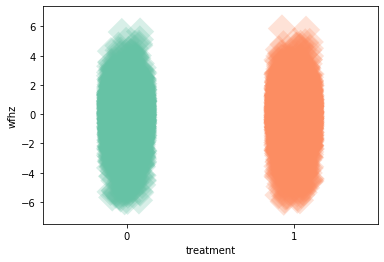

In [30]:
ax = sns.stripplot(x=table_4_data['treatment'], y = table_4_data['wfhz'],
                         palette="Set2", size=20, marker="D", 
                   edgecolor="gray", alpha=.25) 

### Table 5 - Program Impact on CHP Interaction and Health Knowledge

In [31]:
#the initial stata file is in version 100 and thus not supported by pandas; saved the initial dataset in Stata 12 version
table_5_data = pd.read_stata("AEJ2018_HHmain_old_stata_version.dta")
table_5_data = table_5_data.set_index(['branchid', 'villageid'], drop = False)
table_5_data.head()  

district  branchid  villageid  treatment  \
branchid villageid                                            
41       1003       10 Arua        41       1003          0   
         1003       10 Arua        41       1003          0   
         1003       10 Arua        41       1003          0   
         1003       10 Arua        41       1003          0   
         1003       10 Arua        41       1003          0   

                    village_hhs_baseline  village_hhsu5_baseline  \
branchid villageid                                                 
41       1003                      116.0                    68.0   
         1003                      116.0                    68.0   
         1003                      116.0                    68.0   
         1003                      116.0                    68.0   
         1003                      116.0                    68.0   

                    village_hhs_endline  village_share_immigrants  \
branchid villageid                                                  
41       1003                     110.0                  0.105263   
         1003                     110.0                  0.105263   
         1003                     110.0                  0.105263   
         1003                     110.0                  0.105263   
         1003                     110.0                  0.105263   

                    village_distance_road  village_distance_electricity  ...  \
branchid villageid                                                       ...   
41       1003                     6.00096                      4.264567  ...   
         1003                     6.00096                      4.264567  ...   
         1003                     6.00096                      4.264567  ...   
         1003                     6.00096                      4.264567  ...   
         1003                     6.00096                      4.264567  ...   

                    _Ibranchid_13  _Ibranchid_22  _Ibranchid_23  \
branchid villageid                                                
41       1003                   0              0              0   
         1003                   0              0              0   
         1003                   0              0              0   
         1003                   0              0              0   
         1003                   0              0              0   

                    _Ibranchid_24 _Ibranchid_25 _Ibranchid_31 _Ibranchid_32  \
branchid villageid                                                            
41       1003                   0             0             0             0   
         1003                   0             0             0             0   
         1003                   0             0             0             0   
         1003                   0             0             0             0   
         1003                   0             0             0             0   

                   _Ibranchid_33 _Ibranchid_41 _Ibranchid_42  
branchid villageid                                            
41       1003                  0             1             0  
         1003                  0             1             0  
         1003                  0             1             0  
         1003                  0             1             0  
         1003                  0             1             0  

[5 rows x 87 columns]

In [32]:
#Household visited by a community health promoter in last 30 days
reg_27 = PanelOLS(table_5_data.HH_interactions_CHPlastmonth, table_5_data.treatment, entity_effects = True) 
res_27 = reg_27.fit(cov_type = 'clustered',clusters = table_5_data.villageid) 
#Diahrrhea from drinking untreated water
reg_28 = PanelOLS(table_5_data.HH_knowledge_diarrhea, table_5_data.treatment, entity_effects = True) 
res_28 = reg_28.fit(cov_type = 'clustered', clusters = table_5_data.villageid) 
#Zinc is effective against diarrhea 
reg_29 = PanelOLS(table_5_data.HH_knowledge_diarrheazinc, table_5_data.treatment, entity_effects = True) 
res_29 = reg_29.fit(cov_type = 'clustered', clusters = table_5_data.villageid) 
#Mosquito bites are the only cause of malaria 
reg_30 = PanelOLS(table_5_data.HH_knowledge_malaria_onlymosq, table_5_data.treatment, entity_effects = True) 
res_30 = reg_30.fit(cov_type = 'clustered', clusters = table_5_data.villageid)  
#Aware of food with added nutrients 
reg_31 = PanelOLS(table_5_data.HH_knowledge_nutrients, table_5_data.treatment, entity_effects = True) 
res_31 = reg_31.fit(cov_type = 'clustered', clusters = table_5_data.villageid) 
#Women should deliver at hospital 
reg_32 = PanelOLS(table_5_data.HH_knowledge_delivery_hf, table_5_data.treatment, entity_effects = True)
res_32 = reg_32.fit(cov_type = 'clustered', clusters = table_5_data.villageid) 
#Bed nets can prevent malaria 
reg_33 = PanelOLS(table_5_data.HH_knowledge_nets, table_5_data.treatment, entity_effects = True)
res_33 = reg_33.fit(cov_type = 'clustered', clusters = table_5_data.villageid)

print(res_27, res_28, res_29, res_30, res_31, res_32, res_33)  

C:\Users\ZEF\anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                               PanelOLS Estimation Summary                                
Dep. Variable:     HH_interactions_CHPlastmonth   R-squared:                        0.0640
Estimator:                             PanelOLS   R-squared (Between):              0.4895
No. Observations:                          7018   R-squared (Within):               0.0640
Date:                          Mon, Jul 13 2020   R-squared (Overall):              0.1845
Time:                                  20:50:10   Log-likelihood                   -2170.6
Cov. Estimator:                       Clustered                                           
                                                  F-statistic:                      479.14
Entities:                                    12   P-value                           0.0000
Avg Obs:                                 584.83   Distribution:                  F(1,7005)
Min Obs:                                 185.00                                           

Average standaridized effect:

In [43]:
control_table_5 = table_5_data[table_5_data.treatment==0] 
control_table_5 = control_table_5.set_index(['branchid', 'villageid'], drop = False)

control_table_5['HH_knowledge_nutrients'] = np.where((control_table_5['HH_knowledge_nutrients'] == 'yes'), 1,0)
control_table_5['HH_knowledge_nets'] = np.where((control_table_5['HH_knowledge_nets'] == 'yes'), 1,0)

std_deviation_diarrhea = np.std(control_table_5.HH_knowledge_diarrhea) 
std_deviation_zink = np.std(control_table_5.HH_knowledge_diarrheazinc)
std_deviation_mosquito = np.std(control_table_5.HH_knowledge_malaria_onlymosq) 
std_deviation_nutrients = np.std(control_table_5.HH_knowledge_nutrients)
std_deviation_nets = np.std(control_table_5.HH_knowledge_nets)
std_deviation_delivery = np.std(control_table_5.HH_knowledge_delivery_hf) 
std_deviations = np.array([std_deviation_diarrhea, std_deviation_zink, std_deviation_mosquito, std_deviation_nutrients,
                           std_deviation_nets,std_deviation_delivery])

standardized_betas = pd.DataFrame(np.array([[0.041, 0.036,0.027,0.047,0.002,0.000], 
                                        [std_deviation_diarrhea, std_deviation_zink,
                                 std_deviation_mosquito, std_deviation_nutrients,
                                 std_deviation_nets, std_deviation_delivery]]),
                                  columns=['diarrhea', 'zink', 'mosquito', 'nutrients', 'nets', 'delivery']).T 
standardized_betas.columns = ['beta', 'std'] 

standardized_betas['std_beta'] = standardized_betas['beta']/standardized_betas['std'] 
average_standardized_effect = standardized_betas['std_beta'].mean() 
 
print(f"Average standardized effect: {average_standardized_effect:5.3f}")    

Average standardized effect: 0.065


### Table 6 - Program Impact on Preventive and Treatment Services

In [54]:
#Child delivery at HF 
delivery = pd.read_stata("AEJ2018_postnatal.dta") 
delivery = delivery.set_index(['branchid', 'villageid'], drop = False)
reg_33 = PanelOLS(delivery.postnatal_nothome, delivery.treatment, entity_effects = True)
res_33 = reg_33.fit(cov_type = 'clustered', clusters = delivery.villageid)  

#Follow-up visit first week post delivery 
reg_34 = PanelOLS(delivery.postnatal_followup, delivery.treatment, entity_effects = True)
res_34 = reg_34.fit(cov_type = 'clustered', clusters = delivery.villageid) 

#Child fully immunized 
reg_35 = PanelOLS(delivery.postnatal_fully_immunized, delivery.treatment, entity_effects = True)
res_35 = reg_35.fit(cov_type = 'clustered', clusters = delivery.villageid)

#Child was breastfed 
breastfeeding = pd.read_stata("AEJ2018_HHroster_u5.dta") 
breastfeeding = breastfeeding.set_index(['branchid', 'villageid'], drop = False) 
reg_36 = PanelOLS(breastfeeding.HHroster_u5_breastfed, breastfeeding.treatment, entity_effects = True)
res_36 = reg_36.fit(cov_type = 'clustered', clusters = breastfeeding.villageid) 

#Child took vitamin A 
vitA = pd.read_stata("AEJ2018_fortified.dta") 
vitA = vitA.set_index(['branchid', 'villageid'], drop = False) 
reg_37 = PanelOLS(vitA.fortified_vitA, vitA.treatment, entity_effects = True)
res_37 = reg_37.fit(cov_type = 'clustered', clusters = vitA.villageid) 

#Child under treated net last night 
malaria = pd.read_stata("AEJ2018_malaria.dta")   
malaria = malaria.set_index(['branchid', 'villageid'], drop = False) 
reg_38 = PanelOLS(malaria.malaria_treatednet, malaria.treatment, entity_effects = True) 
res_38 = reg_38.fit(cov_type = 'clustered', clusters = malaria.villageid) 

#Child with malaria treated with ACT 
reg_39 = PanelOLS(malaria.malaria_ACT_3d, malaria.treatment, entity_effects = True) 
res_39 = reg_39.fit(cov_type = 'clustered', clusters = malaria.villageid)

#Treat water before drinking 
reg_40 = PanelOLS(table_5_data.HH_bheavior_treatwater, table_5_data.treatment, entity_effects = True) 
res_40 = reg_40.fit(cov_type = 'clustered', clusters = table_5_data.villageid)

#Child with dirrhea treated with ORS/zinc 
diarrhea = pd.read_stata("AEJ2018_diarrhea.dta") 
diarrhea = diarrhea.set_index(['branchid', 'villageid'], drop = False)
reg_41 = PanelOLS(diarrhea.diarrhea_ORSZinc, diarrhea.treatment, entity_effects = True) 
res_41 = reg_41.fit(cov_type = 'clustered', clusters = diarrhea.villageid) 

print(res_33, res_34, res_35, res_36, res_37, res_38, res_39, res_40, res_41)    

                          PanelOLS Estimation Summary                           
Dep. Variable:      postnatal_nothome   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):              0.0124
No. Observations:                1955   R-squared (Within):               0.0002
Date:                Mon, Jul 13 2020   R-squared (Overall):              0.0110
Time:                        21:57:11   Log-likelihood                   -677.68
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.3964
Entities:                          12   P-value                           0.5290
Avg Obs:                       162.92   Distribution:                  F(1,1942)
Min Obs:                       52.000                                           
Max Obs:                       513.00   F-statistic (robust):             0.2526
                            

Average standardized effect

In [36]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [56]:
delivery = delivery[['postnatal_nothome', 'postnatal_followup', 'hhid', 'treatment',
                     'branchid', 'villageid', 'postnatal_womanID', 'postnatal_fully_immunized']] 
delivery = delivery.set_index(['branchid', 'villageid'], drop = False) 
delivery_controls = delivery[delivery.treatment == 0]
std_delivery = np.std(delivery_controls.postnatal_nothome)
std_followup = np.std(delivery_controls.postnatal_followup)
std_immunization = np.std(delivery_controls.postnatal_fully_immunized)

malaria = malaria[['malaria_ACT_3d', 'hhid', 'treatment', 'branchid', 'villageid', 'childID', 'malaria_treatednet']] 
malaria = malaria.set_index(['branchid', 'villageid'], drop = False) 
malaria_controls = malaria[malaria.treatment == 0] 
std_malaria = np.std(malaria_controls.malaria_treatednet) 
std_malaria_ACT = np.std(malaria_controls.malaria_ACT_3d) 

breastfeeding = breastfeeding[['HHroster_u5_breastfed', 'hhid', 'treatment', 'branchid', 'villageid', 'childID']] 
breastfeeding = breastfeeding.set_index(['branchid', 'villageid'], drop = False) 
breast_controls = breastfeeding[breastfeeding.treatment == 0]
std_breastfed = np.std(breast_controls.HHroster_u5_breastfed)

vitA = vitA[['fortified_vitA', 'hhid', 'treatment', 'branchid', 'villageid', 'childID']] 
vitA = vitA.set_index(['branchid', 'villageid'], drop = False) 
vitA_controls = vitA[vitA.treatment == 0]
std_vitA = np.std(vitA_controls.fortified_vitA) 

water = table_5_data[['HH_bheavior_treatwater', 'hhid', 'treatment', 'branchid', 'villageid']] 
water = water.set_index(['branchid', 'villageid'], drop = False) 
water_controls = water[water.treatment == 0] 
water_controls['HH_bheavior_treatwater'] = np.where((water_controls['HH_bheavior_treatwater'] == 'yes'), 1,0)
std_water = np.std(water_controls.HH_bheavior_treatwater) 

diarrhea = diarrhea[['diarrhea_ORSZinc', 'hhid', 'treatment', 'branchid', 'villageid', 'childID']]
diarrhea = diarrhea.set_index(['branchid', 'villageid'], drop = False) 
diarrhea_controls = diarrhea[diarrhea.treatment==0] 
std_diarrhea = np.std(diarrhea_controls.diarrhea_ORSZinc)

std_deviations = np.array([std_delivery, std_followup, std_immunization, std_malaria,
                          std_malaria_ACT, std_breastfed, std_vitA, std_water, std_diarrhea]) 

standardized_betas = pd.DataFrame(np.array([[0.010, 0.0809, -0.0023, 0.0510, 0.0039, -0.0051, 0.0006, 0.0372, 0.0533], 
                                        [std_delivery, std_followup, std_immunization, std_malaria,
                          std_malaria_ACT, std_breastfed, std_vitA, std_water, std_diarrhea]]),
                                  columns=['delivery', 'follow-up', 'immunization', 'malaria', 'malaria_ACT',
                                           'breastfed', 'vitamin A', 'water', 'diarrhea']).T 
standardized_betas.columns = ['beta', 'std'] 

standardized_betas['std_beta'] = standardized_betas['beta']/standardized_betas['std'] 
average_standardized_effect = standardized_betas['std_beta'].mean() 
 
print(f"Average standardized effect: {average_standardized_effect:5.3f}")  

Average standardized effect: 0.061


### Extension 

As an independent contribution to the paper, I first look at the drivers of high under-5 child mortality rate in Uganda in 2012, i.e. one year prior to the treatment evalution. An understanding of the main causes of child mortality before the treatment evaluation, may provide an intuition for a successive mediation analysis. In particular, we will try to elicit which vector of Community Health Promoters' (CHP) activity (e.g. selling anti-malaria drugs, educating households on pregnancy and childcare, etc.) played the major role in reducing child mortality rate in 2013. To guess the activities that may have mediated the effect of the program, let's first look at what factors constitute child mortality in Uganda. 

In [10]:
sepsis = pd.read_csv("Uganda numbers 2012/sepsis and other infectious conditions of the newborn.csv")  
sepsis['cause'] = 'Sepsis and other infectious conditions of the newborn'
sepsis['age'] = "1-59 months" 
sepsis = sepsis.drop(sepsis.index[[0,1,2]]) 
sepsis = sepsis.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
sepsis = sepsis.rename(index={3: "1"})

prematurity = pd.read_csv("Uganda numbers 2012/prematurity.csv") 
prematurity['cause'] = 'Prematurity'
prematurity['age'] = "1-59 months" 
prematurity = prematurity.drop(prematurity.index[[0,1,2]]) 
prematurity = prematurity.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
prematurity = prematurity.rename(index={3: "2"})

other = pd.read_csv("Uganda numbers 2012/other noncommunicable diseases.csv") 
other['cause'] = 'Other noncommunicable diseases' 
other['age'] = "1-59 months" 
other = other.drop(other.index[[0,1,2]]) 
other = other.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
other = other.rename(index={3: "3"}) 

other_2 = pd.read_csv("Uganda numbers 2012/other communicable perinatal and nutritional conditions.csv") 
other_2['cause'] = 'Other communicable, perinatal and nutritional conditions' 
other_2['age'] = "1-59 months"  
other_2 = other_2.drop(other_2.index[[0,1,2]]) 
other_2 = other_2.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
other_2 = other_2.rename(index={3: "4"}) 

meningitis = pd.read_csv("Uganda numbers 2012/meningitis encephalitis.csv") 
meningitis['cause'] = 'Meningitis/encephalitis' 
meningitis['age'] = "1-59 months"  
meningitis = meningitis.drop(meningitis.index[[0,1,2]]) 
meningitis = meningitis.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
meningitis = meningitis.rename(index={3: "5"}) 

measles = pd.read_csv("Uganda numbers 2012/measles.csv") 
measles['cause'] = 'Measles'
measles['age'] = "1-59 months"  
measles = measles.drop(measles.index[[0,1,2]]) 
measles = measles.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
measles = measles.rename(index={3: "6"})  

malaria =  pd.read_csv("Uganda numbers 2012/malaria.csv") 
malaria['cause'] = 'Malaria'
malaria['age'] = "1-59 months"  
malaria = malaria.drop(malaria.index[[0,1,2]]) 
malaria = malaria.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
malaria = malaria.rename(index={3: "7"})   

aids = pd.read_csv("Uganda numbers 2012/hiv aids.csv") 
aids['cause'] = 'HIV/AIDS'
aids['age'] = "1-59 months"  
aids = aids.drop(aids.index[[0,1,2]]) 
aids = aids.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
aids = aids.rename(index={3: "8"}) 

diarrhea = pd.read_csv("Uganda numbers 2012/diarrhoeal diseases.csv") 
diarrhea['cause'] = 'Diarrhoeal diseases'
diarrhea['age'] = "1-59 months"  
diarrhea = diarrhea.drop(diarrhea.index[[0,1,2]]) 
diarrhea = diarrhea.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
diarrhea = diarrhea.rename(index={3: "9"})   

congenital = pd.read_csv("Uganda numbers 2012/congenital anomalities.csv") 
congenital['cause'] = 'Congenital anomalies'
congenital['age'] = "1-59 months"  
congenital = congenital.drop(congenital.index[[0,1,2]]) 
congenital = congenital.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
congenital = congenital.rename(index={3: "10"})  

asphyxia = pd.read_csv("Uganda numbers 2012/birth asphyxia and birth trauma.csv")  
asphyxia['cause'] = 'Birth asphyxia and birth trauma'
asphyxia['age'] = "1-59 months"  
asphyxia = asphyxia.drop(asphyxia.index[[0,1,2]]) 
asphyxia = asphyxia.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
asphyxia = asphyxia.rename(index={3: "11"})  

respiratory = pd.read_csv("Uganda numbers 2012/acute lower respiratory infections.csv") 
respiratory['cause'] = 'Acute lower respiratory infections'
respiratory['age'] = "1-59 months"  
respiratory = respiratory.drop(respiratory.index[[0,1,2]]) 
respiratory = respiratory.rename(columns={"Unnamed: 0": "Country", "2012": "Number of child deaths"}) 
respiratory = respiratory.rename(index={3: "12"}) 

frames = [sepsis, prematurity, other, other_2, meningitis, measles,
          malaria, aids, diarrhea, congenital, asphyxia, respiratory] 
df = pd.concat(frames)
df['year'] = 2012 
df['Number of child deaths']=df['Number of child deaths'].astype(int) 
df['Total number of child deaths'] = df['Number of child deaths'].iloc[1:12].sum(axis=0) 
df['Proportion'] = (df['Number of child deaths']/df['Total number of child deaths']) * 100
df.head(13)   

,Country,Number of child deaths,cause,age,year,Total number of child deaths,Proportion
1,Uganda,0,Sepsis and other infectious conditions of the ...,1-59 months,2012,60512,0.000000
2,Uganda,1517,Prematurity,1-59 months,2012,60512,2.506941
3,Uganda,3517,Other noncommunicable diseases,1-59 months,2012,60512,5.812070
4,Uganda,9203,"Other communicable, perinatal and nutritional ...",1-59 months,2012,60512,15.208554
5,Uganda,2435,Meningitis/encephalitis,1-59 months,2012,60512,4.023995
6,Uganda,405,Measles,1-59 months,2012,60512,0.669289
7,Uganda,11212,Malaria,1-59 months,2012,60512,18.528556
8,Uganda,4907,HIV/AIDS,1-59 months,2012,60512,8.109135
9,Uganda,8823,Diarrhoeal diseases,1-59 months,2012,60512,14.580579
10,Uganda,2897,Congenital anomalies,1-59 months,2012,60512,4.787480


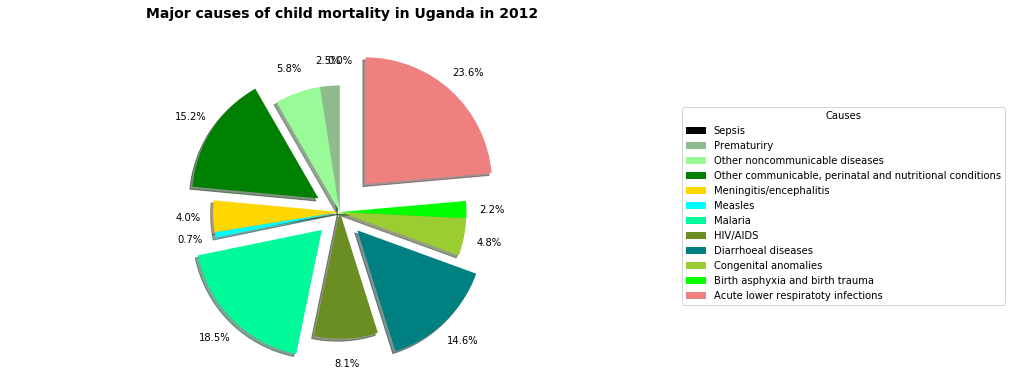

In [11]:
causes = 'Sepsis', 'Prematuriry', 'Other noncommunicable diseases', 'Other communicable, perinatal and nutritional conditions', 'Meningitis/encephalitis', 'Measles', 'Malaria','HIV/AIDS','Diarrhoeal diseases', 'Congenital anomalies', 'Birth asphyxia and birth trauma','Acute lower respiratoty infections'    
sizes = df['Proportion']
explode = (0,0,0,0.2,0,0,0.2,0,0.2,0,0,0.3) 
fig1, ax1 = plt.subplots(figsize=(12, 6)) 
colors = ['black','darkseagreen', 'palegreen', 'green', 'gold', 'cyan', 'mediumspringgreen', 'olivedrab', 'teal',
          'yellowgreen', 'lime', 'lightcoral']
ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = colors,
        pctdistance=1.2, labeldistance=10) 
ax1.set_title('Major causes of child mortality in Uganda in 2012', fontsize = 14, fontweight = 'bold')
ax1.legend(causes,
          title="Causes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1)) 
ax1.axis('equal')  
plt.show()     

### Notes 

<span id="fn1"> The mapping of child mortality was done in R, here is the code</span>

In [12]:
%%R
#                                    preparation of WHO data

mortality_rates <- read.csv("probability of dying per 1000 live births.csv")

colnames(mortality_rates)
#renaming columns for ease
names(mortality_rates)[names(mortality_rates)=="Under.5.mortality.rate"] <- "u5"
names(mortality_rates)[names(mortality_rates)=="Infant.mortality.rate"] <- "infants"
names(mortality_rates)[names(mortality_rates)=="Neonatal.mortality.rate"] <- "neonatal"

#####In introduction authors mention 2017 statistics, so I also keep only 2017
mortality_rates <- filter(mortality_rates, Year == 2017)

#####Grouping countries into 6 categories according to their mortality rates of children under-5
mortality_rates$range <- cut2(mortality_rates$u5,7)
mortality_rates$group <- as.numeric(cut2(mortality_rates$u5, g=7))

#uplading ISO-3 codes for further merging
iso_codes <- ISO_3166_1
colnames(iso_codes)
names(iso_codes)[names(iso_codes)  == "Alpha_3"] <- "ISO3_Code"
iso_codes <- subset(iso_codes, select = c("ISO3_Code", "Name"))

#merging 
mortality_rates <- merge(mortality_rates, iso_codes, by.x = "Country", by.y = "Name", all.x = TRUE)
#some countries were not assigned an ISO-3 code
######## assigning ISO-3 codes#######
mortality_rates$ISO3_Code[which(mortality_rates$Country == "Bolivia (Plurinational State of)")] <- "BOL"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "CÃ´te d'Ivoire")] <- "CIV"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "Democratic People's Republic of Korea")] <- "PRK"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "Democratic Republic of the Congo")] <- "COD"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "Iran (Islamic Republic of)")] <- "IRN"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "Micronesia (Federated States of)")] <- "FSM"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "Republic of Korea")] <- "KOR"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "Republic of Moldova")] <- "MDA"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "Republic of North Macedonia")] <- "MKD"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "United Kingdom of Great Britain and Northern Ireland")] <-"GBR"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "United Republic of Tanzania")] <- "TZA"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "United States of America")] <- "USA"
mortality_rates$ISO3_Code[which(mortality_rates$Country == "Venezuela (Bolivarian Republic of)")] <- "VEN" 

In [ ]:
%%R 
#install.packages('tmap', repos='http://cran.us.r-project.org')
#library('tmap')  ----- kernel dies (?)
 
##### World map #####
data("World")
WHO_2017 <- merge(World, mortality_rates, by.x = "iso_a3", by.y="ISO3_Code", all.x=TRUE)
colnames(WHO_2017)
WHO_2017 <- subset(WHO_2017, select = c("iso_a3", "Country", "Year", "u5", "infants", "neonatal", "group", 
                                        "range", "geometry"))

#####Mapping child mortality rates, under-5####
tmap_options(max.categories = 177)
#Under-5 child mortality rate, 2017 
tmap_mode("plot")
tm_shape(WHO_2017) +
  tm_polygons("group",
              title = "Child mortality rate (<5 yrs), WHO 2017",
              palette = "Accent", labels = c("I(lowest mortality rate)", "II", "III", "IV",
                                             "V", "VI((highest highest mortality rate)")) +
  tm_layout(bg.color = "skyblue", legend.outside = TRUE) +
  tm_shape(World) +
  tm_borders("black", lwd = .5) +
  tm_text("iso_a3", size = "AREA")
